# Analyze Dataset
---
1. Encode email data using BERT.
2. Split data into test and train splits.
3. Train an SVM model to predict the class of an email.
4. Test the model on unseen emails.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import joblib
import platform

/home/prokope/Projects/PsyberWatch/.svm-venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


## Load Data

In [2]:
email_dataframe = pd.read_feather("./data/2_balanced_email_dataset.feather")

# Encode "Email Type" into a numerical format: 0 for ham, 1 for phishing, and 2 for spam
email_dataframe["label_id"] = email_dataframe["Email Type"].astype("category").cat.codes

## Encode Email Text using SBERT

Activate CUDA if available.

In [3]:
if platform.system() in ["Windows", "Linux"]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
elif platform.system() == "Darwin":
    device = "mps" if torch.backends.mps.is_available() else "cpu"
else:
    device = "cpu"

# Store the variable to be used in 5. Demo Classify Emails.ipynb
%store device

print("Using device:", device)

Stored 'device' (str)
Using device: cuda


In [4]:
# Load a BERT-based encoder
model = SentenceTransformer("all-MiniLM-L6-v2", device=device)

# Encode emails
X = model.encode(
    email_dataframe['Email Text'].tolist(),
    convert_to_numpy=True,
    batch_size=32,
    show_progress_bar=True
)

/home/prokope/Projects/PsyberWatch/.svm-venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|█████████████████████████████████████████████████| 1610/1610 [00:36<00:00, 43.93it/s]


In [6]:
# Labels
y = email_dataframe['label_id']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train SVM classifier
clf = SVC(kernel="linear", class_weight="balanced")
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Results
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3434
           1       0.95      0.96      0.95      3434
           2       1.00      1.00      1.00      3435

    accuracy                           0.97     10303
   macro avg       0.97      0.97      0.97     10303
weighted avg       0.97      0.97      0.97     10303



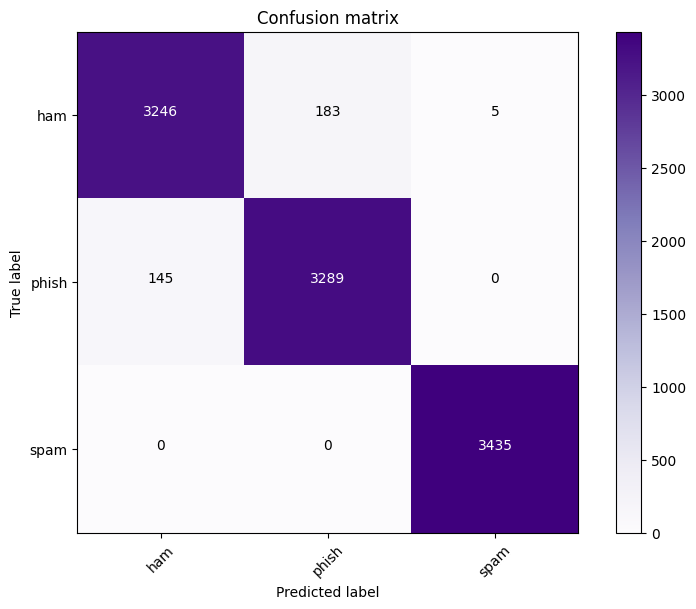

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
class_names = email_dataframe["Email Type"].unique()


plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Save as `.joblib` file for later reuse.

In [8]:
Path("./models").mkdir(parents=True, exist_ok=True)
joblib.dump(clf, "./models/svm_model.joblib")

['./models/svm_model.joblib']

### Alternative: Use Raw BERT via HuggingFace Transformers

In [26]:
# import torch
# from transformers import BertTokenizer, BertModel
# import numpy as np

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
# model.eval()

# def bert_encode(text):
#     inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=256)
#     with torch.no_grad():
#         outputs = model(**inputs)
#     cls_embedding = outputs.last_hidden_state[:,0,:].numpy()   # CLS token
#     return cls_embedding.flatten()

# # Encode entire column
# X = np.vstack([bert_encode(t) for t in email_dataframe['Email Text']])
